<a href="https://colab.research.google.com/github/nishesh29/Attribute_Marketing-Marketing_Mix_Models/blob/main/Generalized_Agents_Colabs/PWS/CM201_base/CM201_base_NO_FOLLOW_UP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sample ID**: CM201_base


**Query**: Is Chase in his office? If he's not, turn off the office fan light, turn on his desk lamps, and send the following message in the "work_discussion" slack channel: "Time to buckle down honey! Please work on your thesis. You got this!".


**DB Type**: Base Case


**Case Description**: The image shows that no one is in the office and the office fan light with name "Office Fan Light" is turned on and the desk lamp with name "Desk Lamp" is turned off. Hence, turn off "Office Fan Light", turn on the "Desk Lamp" and send the following message in the "work_discussion" slack channel: "Time to buckle down honey! Please work on your thesis. You got this!".

**Global/Context Variables:**

- slack_channel = "work_discussion"
- slack_message = "Time to buckle down honey! Please work on your thesis. You got this!"

**APIs:**
- home_assistant
- sdm
- slack

# Set Up

## Download relevant files

In [17]:
import io
import os
import sys
import zipfile
import shutil
import re
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

VERSION = "0.1.4"  # Pass the version of the API
CONTENT_DIR = '/content'
APIS_DIR = os.path.join(CONTENT_DIR, 'APIs')
DBS_DIR = os.path.join(CONTENT_DIR, 'DBs')
SCRIPTS_DIR = os.path.join(CONTENT_DIR, 'Scripts')
FC_DIR = os.path.join(CONTENT_DIR, 'Schemas')
ZIP_PATH = os.path.join(CONTENT_DIR, f'APIs_V{VERSION}.zip')

APIS_FOLDER_ID = '1QpkAZxXhVFzIbm8qPGPRP1YqXEvJ4uD4'
ITEMS_TO_EXTRACT = ['APIs/', 'DBs/', 'Scripts/', 'Schemas/']

# Cleanup
for path in [APIS_DIR, DBS_DIR, SCRIPTS_DIR, FC_DIR, ZIP_PATH]:
    if os.path.exists(path):
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.remove(path)

# Auth
auth.authenticate_user()
drive_service = build('drive', 'v3')

def download_drive_file(service, file_id, output_path, file_name=None, show_progress=True):
    request = service.files().get_media(fileId=file_id)
    with io.FileIO(output_path, 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            if show_progress:
                print(f"Download progress: {int(status.progress() * 100)}%")

print(f"Searching for APIs zip file with version {VERSION} in folder: {APIS_FOLDER_ID}...")
apis_file_id = None
try:
    query = f"'{APIS_FOLDER_ID}' in parents and trashed=false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    for file in results.get('files', []):
        if file['name'].lower() == f'apis_v{VERSION.lower()}.zip':
            apis_file_id = file['id']
            print(f"Found: {file['name']} (ID: {apis_file_id})")
            break
except Exception as e:
    print(f"Error listing files: {e}")

if not apis_file_id:
    sys.exit(f"❌ APIs zip V{VERSION} not found.")

print(f"Downloading APIs zip {apis_file_id}...")
download_drive_file(drive_service, apis_file_id, ZIP_PATH)

print(f"Extracting {ZIP_PATH}...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    for member in zip_ref.namelist():
        if any(member.startswith(p) for p in ITEMS_TO_EXTRACT):
            zip_ref.extract(member, CONTENT_DIR)

os.remove(ZIP_PATH)

if os.path.exists(APIS_DIR):
    sys.path.append(APIS_DIR)

for p in [APIS_DIR, DBS_DIR, SCRIPTS_DIR]:
    print(f"{'✅' if os.path.exists(p) else '❌'} {p}")

# PWS: Copy pws_image_data folder in /content/pws_image_data
print(f"\nDownloading all files from pws_images_data Drive folder.")
IMAGES_ZIP_ID = '1MlgE9LnFA221ARh9l4nbF1yGc215KDN_'
IMAGES_ZIP_PATH = os.path.join(CONTENT_DIR, 'pws_images_data.zip')
download_drive_file(drive_service, IMAGES_ZIP_ID, IMAGES_ZIP_PATH, file_name='pws_images_data.zip')

print(f"Extracting images from {IMAGES_ZIP_PATH} to {CONTENT_DIR}...")
try:
    with zipfile.ZipFile(IMAGES_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(CONTENT_DIR)

except zipfile.BadZipFile:
    print(f"Error: The downloaded file at {IMAGES_ZIP_PATH} is not a valid zip file.")
    sys.exit("Invalid zip file downloaded.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")
    sys.exit("Extraction failed.")

if os.path.exists(IMAGES_ZIP_PATH):
    os.remove(IMAGES_ZIP_PATH)

Searching for APIs zip file with version 0.1.4 in folder: 1QpkAZxXhVFzIbm8qPGPRP1YqXEvJ4uD4...
Found: APIs_V0.1.4.zip (ID: 1TnAaWGfVrMxWTilyhy46-Aue_bh0XkNk)
Download progress: 100%
Extracting /content/APIs_V0.1.4.zip...
✅ /content/APIs
✅ /content/DBs
✅ /content/Scripts

Download progress: 78%
Download progress: 100%
Extracting images from /content/pws_images_data.zip to /content...


## Install Dependencies and Clone Repositories

In [18]:
!pip install uv
!uv pip install -r /content/APIs/requirements.txt
!uv pip install jsonpath_ng

Using Python 3.12.12 environment at: /usr
Audited 50 packages in 147ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 130ms


## Import APIs and initiate DBs

In [19]:
scenario_db = {'environment': {'home_assistant': {'devices': {'LIGHT_001': {'attributes': {'brightness': 1.0,
                                                                             'company': 'Crompton',
                                                                             'model': '4Ft.22W',
                                                                             'serial_number': 'C907890',
                                                                             'state': 'On',
                                                                             'supports_color': 'No'},
                                                              'name': 'LivingRoom '
                                                                      'Light 1',
                                                              'type': 'Light'},
                                                'LIGHT_002': {'attributes': {'brightness': 1.0,
                                                                             'company': 'Crompton',
                                                                             'model': '4Ft.22W',
                                                                             'serial_number': 'C847116',
                                                                             'state': 'On',
                                                                             'supports_color': 'No'},
                                                              'name': 'LivingRoom '
                                                                      'Light 2',
                                                              'type': 'Light'},
                                                'LIGHT_003': {'attributes': {'brightness': 0.8,
                                                                             'company': 'Crompton',
                                                                             'model': '3Ft.15W',
                                                                             'serial_number': 'C170567',
                                                                             'state': 'On',
                                                                             'supports_color': 'No'},
                                                              'name': 'Office '
                                                                      'Fan '
                                                                      'Light',
                                                              'type': 'Light'},
                                                'LIGHT_004': {'attributes': {'brightness': 1.0,
                                                                             'color': '#FF0000',
                                                                             'company': 'Crompton '
                                                                                        'Multi-Color',
                                                                             'model': '4Ft.22W '
                                                                                      '- '
                                                                                      '3 '
                                                                                      'in '
                                                                                      '1',
                                                                             'serial_number': 'C956341',
                                                                             'state': 'Off',
                                                                             'supports_color': 'Yes'},
                                                              'name': 'Desk '
                                                                      'Lamp',
                                                              'type': 'Light'},
                                                'TV_001': {'attributes': {'company': 'Samsung',
                                                                          'model': '1.63 '
                                                                                   'm '
                                                                                   '(65) '
                                                                                   'QN900F '
                                                                                   'Neo '
                                                                                   'QLED '
                                                                                   '8K '
                                                                                   'Smart '
                                                                                   'TV',
                                                                          'serial_number': 'QN65Q800TAFXGV',
                                                                          'state': 'On'},
                                                           'name': 'Samsung '
                                                                   'Smart TV - '
                                                                   'LivingRoom',
                                                           'type': 'tv'}}},
                 'sdm': {'devices': {'CAM_001': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'IQ '
                                                                         'Outdoor',
                                                                'parent': 'enterprises/house-system-23005/structures/STRCT1/rooms/OUT1',
                                                                'serial_number': 'GN-IQ-O-128050',
                                                                'state': 'On'},
                                                 'name': 'Courtyard',
                                                 'type': 'Camera'},
                                     'CAM_002': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'Indoor',
                                                                'parent': 'enterprises/house-system-23005/structures/STRCT2/rooms/ROOM1',
                                                                'serial_number': 'GN-I-294458',
                                                                'state': 'On'},
                                                 'name': 'Office',
                                                 'type': 'Camera'},
                                     'CAM_003': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'Indoor',
                                                                'parent': 'enterprises/house-system-23005/structures/STRCT2/rooms/ROOM2',
                                                                'serial_number': 'GN-I-239879',
                                                                'state': 'On'},
                                                 'name': 'Living Room',
                                                 'type': 'Camera'}},
                         'structures': [{'name': 'enterprises/house-system-23005/structures/STRCT1',
                                         'traits': {'sdm.structures.traits.Info': {'customName': 'House '
                                                                                                 '- '
                                                                                                 'Outdoors'}}},
                                        {'name': 'enterprises/house-system-23005/structures/STRCT2',
                                         'traits': {'sdm.structures.traits.Info': {'customName': 'House '
                                                                                                 '- '
                                                                                                 'Indoors'}}}]}},
 'project_id': 'home-office-23005'}

image_map = {'cameras': {'CAM_001': [{'expected': 'No',
                          'image_path': './pws_image_data/2025_05_21.19.38.49.jpg'}],
             'CAM_002': [{'expected': 'Yes',
                          'image_path': './pws_image_data/2025_05_21.21.51.00.jpg',
                          'state': {'light': 'Off'}},
                         {'expected': 'No',
                          'image_path': './pws_image_data/2025_05_21.21.51.26.jpg',
                          'state': {'light': 'On'}}],
             'CAM_003': [{'expected': 'No',
                          'image_path': './pws_image_data/2025_05_21.09.53.16.jpg'}]},
 'events': []}


import json

with open("/content/scenario_db.json", "w") as f:
    json.dump(scenario_db, f)

with open("/content/image_map.json", "w") as f:
    json.dump(image_map, f)


import os
import json

import home_assistant
import sdm
import slack

# Define Context variables
slack_channel = "work_discussion"
slack_message = "Time to buckle down honey! Please work on your thesis. You got this!"

# Local variables
office_desk_lamp="Desk Lamp"

# Initialize DBs
home_assistant.SimulationEngine.db.load_state(f"/content/scenario_db.json")
sdm.SimulationEngine.db.load_state(f"/content/scenario_db.json")
slack.SimulationEngine.db.load_state("/content/DBs/SlackDefaultDB.json")

# Print the DBs
print(f"Home Assistant DB: {home_assistant.SimulationEngine.db.DB}")
print(f"SDM DB: {sdm.SimulationEngine.db.DB}")
print(f"Slack DB: {slack.SimulationEngine.db.DB}")

# Load image map for this task
with open("/content/image_map.json", "r") as f:
    image_map = json.load(f)

# Print the Image Map
print(f"Image Map: {image_map}")

# Reset states
sdm.devices.commands.reset_served_images()
sdm.SimulationEngine.db.reset_state_env()

# Initialize image map
sdm.SimulationEngine.db.update_state_dict(image_map)

# Set events
sdm.SimulationEngine.events.set_cameras_events(image_map, home_assistant.SimulationEngine.db.DB.get("project_id", ""))

# Creating the channel on slack, so that it can be used later for messaging. Ideally it would already be present.
slack.create_channel(slack_channel, is_private=True)

# Set state variable
influencing_device = home_assistant.get_id_by_name(office_desk_lamp)
sdm.SimulationEngine.db.set_state_env([influencing_device])

Home Assistant DB: {'environment': {'home_assistant': {'devices': {'LIGHT_001': {'attributes': {'brightness': 1.0, 'company': 'Crompton', 'model': '4Ft.22W', 'serial_number': 'C907890', 'state': 'On', 'supports_color': 'No'}, 'name': 'LivingRoom Light 1', 'type': 'Light'}, 'LIGHT_002': {'attributes': {'brightness': 1.0, 'company': 'Crompton', 'model': '4Ft.22W', 'serial_number': 'C847116', 'state': 'On', 'supports_color': 'No'}, 'name': 'LivingRoom Light 2', 'type': 'Light'}, 'LIGHT_003': {'attributes': {'brightness': 0.8, 'company': 'Crompton', 'model': '3Ft.15W', 'serial_number': 'C170567', 'state': 'On', 'supports_color': 'No'}, 'name': 'Office Fan Light', 'type': 'Light'}, 'LIGHT_004': {'attributes': {'brightness': 1.0, 'color': '#FF0000', 'company': 'Crompton Multi-Color', 'model': '4Ft.22W - 3 in 1', 'serial_number': 'C956341', 'state': 'Off', 'supports_color': 'Yes'}, 'name': 'Desk Lamp', 'type': 'Light'}, 'TV_001': {'attributes': {'company': 'Samsung', 'model': '1.63 m (65) QN9

# Initial Assertion

1. Assert that the "work_discussion" slack channel exists.
2. Assert that no message has been sent in the "work_discussion" with message body "Time to buckle down honey! Please work on your thesis. You got this!".
3. Assert that the office fan light is on
4. Assert that the desk lamp is off

In [20]:
import home_assistant
import sdm
import slack
from Scripts.assertions_utils import *

# Define Context variables
slack_channel = "work_discussion"
slack_message = "Time to buckle down honey! Please work on your thesis. You got this!"

# Local variables
office_fan_name = "Office Fan Light"
office_desk_lamp = "Desk Lamp"

# 1. Assert that the "work_discussion" slack channel exists
channel_flag = False
slack_channels = slack.list_channels()
for channel in slack_channels['channels']:
    if compare_strings(channel.get("name", ""), slack_channel):
        channel_flag = True
        break
assert channel_flag, f"Channel {slack_channel} does not exist."

# 2. Assert that no message has been sent in the "work_discussion" with the given message body
search_query = f"in:#{slack_channel} {slack_message}"
filtered_messages = slack.search_messages(search_query)
assert len(filtered_messages) == 0, f"Found {len(filtered_messages)} Slack messages, expected 0."

# 3. Assert that the office fan light is turned On
office_fan_name_id = home_assistant.get_id_by_name(office_fan_name)
office_fan_name_state = home_assistant.get_state(office_fan_name_id)
assert compare_strings(office_fan_name_state.get("state", ""), "On"), \
    "Light is turned off in office room, expected it to be on."

# 4. Assert that the desk lamp is Off
office_desk_lamp_id = home_assistant.get_id_by_name(office_desk_lamp)
office_desk_lamp_state = home_assistant.get_state(office_desk_lamp_id)
assert compare_strings(office_desk_lamp_state.get("state", ""), "Off"), \
    "Office desk lamp is turned on, expected it to be off."


# Action
* Locate the Office camera
* Access current footage "2025/05/21.21.51.00"
* Office fan light is on and desk lamp is off
* Turn off "Office Fan Light".
* Turn on "Office Desk Lamp".
* Send slack message "Time to buckle down honey! Please work on your thesis. You got this!" on "work_discussion" channel.


In [21]:
import home_assistant
import sdm
import slack
import base64
from IPython.display import Image, display

def display_base64_image(image_base64):
    """Helper function to display a base 64 image"""
    base64_string = image_base64.split(':')[1].strip()

    try:
        missing_padding = len(base64_string) % 4
        if missing_padding:
            base64_string += '=' * (4 - missing_padding)
        image_data = base64.b64decode(base64_string)
    except Exception as e:
        print(f"Error decoding base64 string: {e}")
        image_data = None

    if image_data:
        display(Image(data=image_data))

# Define Context variables
slack_channel = "work_discussion"
slack_message = "Time to buckle down honey! Please work on your thesis. You got this!"

# 1. List all relevant devices
# List all the lights
devices = home_assistant.list_devices("Light").get("entities", [])
print(f"All available home assistant devices: {devices}")

# List all sdm devices
sdm_devices = sdm.list_devices()
print(f"All available SDM devices: {sdm_devices}")

All available home assistant devices: [{'LIGHT_001': {'attributes': {'brightness': 1.0, 'company': 'Crompton', 'model': '4Ft.22W', 'serial_number': 'C907890', 'state': 'On', 'supports_color': 'No'}, 'name': 'LivingRoom Light 1', 'type': 'Light'}}, {'LIGHT_002': {'attributes': {'brightness': 1.0, 'company': 'Crompton', 'model': '4Ft.22W', 'serial_number': 'C847116', 'state': 'On', 'supports_color': 'No'}, 'name': 'LivingRoom Light 2', 'type': 'Light'}}, {'LIGHT_003': {'attributes': {'brightness': 0.8, 'company': 'Crompton', 'model': '3Ft.15W', 'serial_number': 'C170567', 'state': 'On', 'supports_color': 'No'}, 'name': 'Office Fan Light', 'type': 'Light'}}, {'LIGHT_004': {'attributes': {'brightness': 1.0, 'color': '#FF0000', 'company': 'Crompton Multi-Color', 'model': '4Ft.22W - 3 in 1', 'serial_number': 'C956341', 'state': 'Off', 'supports_color': 'Yes'}, 'name': 'Desk Lamp', 'type': 'Light'}}]
All available SDM devices: {'devices': [{'name': 'enterprises/home-office-23005/devices/CAM_0

In [22]:
# Set required ids

office_fan_id = "LIGHT_003"

office_desk_lamp_id = "LIGHT_004"

office_cam = "CAM_002"

project_id = "home-office-23005"

generate_stream_command = {"command": "sdm.devices.commands.generate_rtsp_stream",
                           "params": {}
                           }
generate_stream_output = sdm.execute_command(device_id=office_cam,project_id=project_id, command_request=generate_stream_command)

# Inspect stream output
print(f"Generated stream output: {generate_stream_output}")

Generated stream output: {'results': {'streamUrls': {'rtspUrl': 'rtsps://sdmvideostream.com/Zy4wLnN0cmVhbWluZ1Rva2VuLi9wd3NfaW1hZ2VfZGF0YS8yMDI1XzA1XzIxLjIxLjUxLjAwLmpwZw==?auth=g.0.streamingToken'}, 'streamExtensionToken': '5z5qxSrQTXOL24inaTyqeg', 'streamToken': 'g.0.streamingToken', 'expiresAt': '2025-10-14T11:25:55.858097'}}


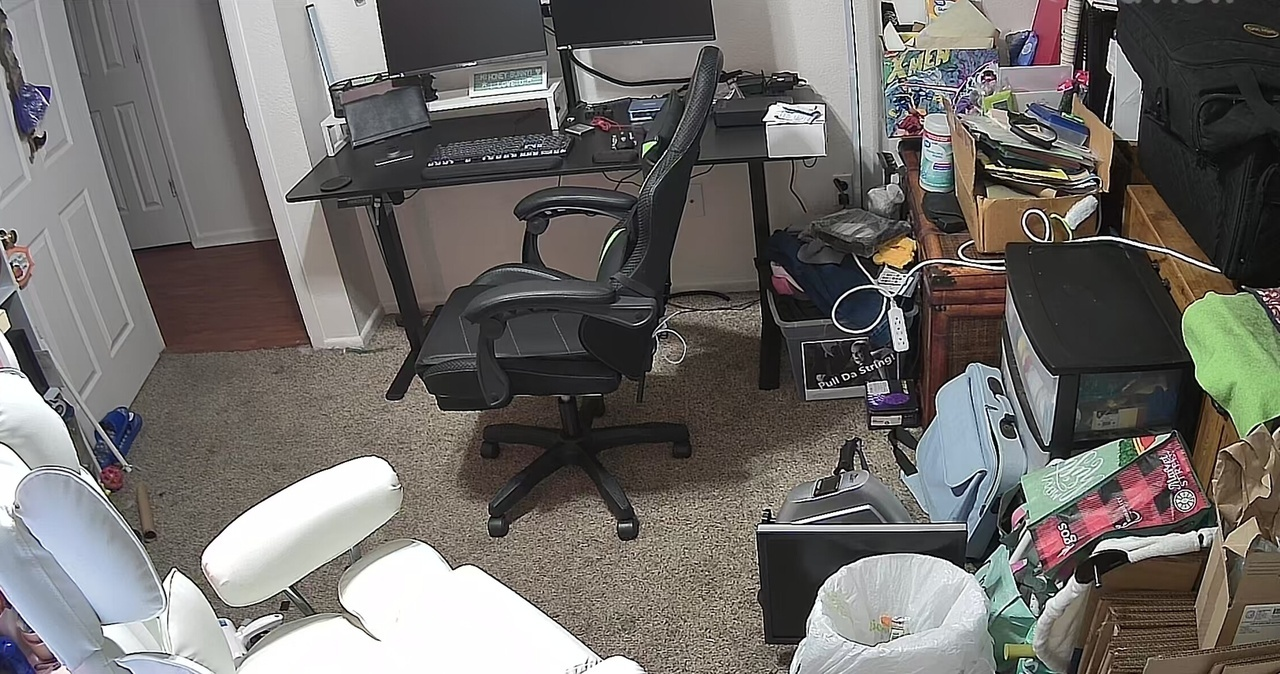

In [23]:
#Access the current footage
#2. Access current footage image from stream
generate_image_command = {"command": "sdm.devices.commands.generate_image_from_rtsp_stream",
                          "params": {
                              "rtsp_url": generate_stream_output.get("results", {}).get("streamUrls", "").get("rtspUrl", "")
                              }
                          }

image_1 = sdm.execute_command(device_id=office_cam, project_id=project_id, command_request=generate_image_command)

# Stop RTSP stream
stop_stream_command = {"command": "sdm.devices.commands.stop_rtsp_stream",
                       "params": {
                           "stream_extension_token": generate_stream_output.get("results", {}).get("streamExtensionToken", "")
                           }
                       }
stop_stream_output = sdm.execute_command(device_id=office_cam, project_id=project_id, command_request=stop_stream_command)
display_base64_image(image_1)

In [24]:
# Mock reply from Gemini
print("The camera feed shows no one in the office room. I'll turn off the fan light, turn on the desk lamp and send the slack message to Chase")

home_assistant.toggle_device(office_fan_id, 'Off')
home_assistant.toggle_device(office_desk_lamp_id, 'On')

# Print the slack channels
slack_channels = slack.list_channels()
print(f"Slack channels: {slack_channels}")

The camera feed shows no one in the office room. I'll turn off the fan light, turn on the desk lamp and send the slack message to Chase
Slack channels: {'ok': True, 'channels': [{'messages': [{'ts': '1688682784.334459', 'user': 'U04L7NE5Q1Y', 'text': "Welcome everyone to the marketing brainstorming session!  Let's kick off by sharing any initial campaign ideas for Q3.", 'reactions': [{'name': 'rocket', 'users': ['U04L7NE5Q1Y', 'U04M2R8JCQ6', 'U04M526DV51'], 'count': 3}]}, {'ts': '1688683000.456789', 'user': 'U04M2R8JCQ6', 'text': 'I think we should focus on a social media campaign highlighting our sustainability initiatives.', 'reactions': [{'name': 'thumbsup', 'users': ['U04L7NE5Q1Y', 'U04M526DV51', 'U04LMCYSD2X'], 'count': 3}]}, {'ts': '1688684000.987654', 'user': 'U04LMCYSD2X', 'text': 'Has anyone seen those interactive ads on platform X?', 'reactions': []}], 'conversations': {}, 'name': 'Default_Channel', 'id': 'C04MKV1KQD6', 'is_private': False, 'team_id': None, 'files': {'F04M89K

In [25]:
# Fetching the correct channel_id based on the slack_channel
channel_id = None
for channel in slack_channels['channels']:
    if channel.get("name") == slack_channel:
        channel_id = channel.get("id")
        break
print(channel_id)

# 5. Send message in the channel
slack.post_chat_message(channel_id, text=slack_message)

C2C7641C0


{'ok': True,
 'message': {'channel': 'C2C7641C0',
  'text': 'Time to buckle down honey! Please work on your thesis. You got this!',
  'attachments': None,
  'blocks': None,
  'user': 'bot',
  'ts': '1760440855.931119',
  'as_user': None,
  'icon_emoji': None,
  'icon_url': None,
  'link_names': None,
  'markdown_text': None,
  'metadata': None,
  'mrkdwn': None,
  'parse': None,
  'reply_broadcast': None,
  'thread_ts': None,
  'unfurl_links': None,
  'unfurl_media': None,
  'username': None}}

# Final Assertion
1. Assert that 1 message has been sent in the "work_discussion" channel with message body "Time to buckle down honey! Please work on your thesis. You got this!".
2. Assert that the office fan light is Off
3. Assert that the desk lamp is on
4. Assert that all relevant images are utilized

In [26]:
import home_assistant
import sdm
import slack
from Scripts.assertions_utils import *

# Define Context variables
slack_channel = "work_discussion"
slack_message = "Time to buckle down honey! Please work on your thesis. You got this!"

# Local variables
office_fan_name = "Office Fan Light"
office_desk_lamp = "Desk Lamp"

# Helper functions
def are_all_images_used(expected_paths: list[str], served_type: str) -> bool:
    """Helper function to verify that all expected images have been used"""
    served_image_paths = sdm.devices.commands.get_served_images()

    if compare_strings(served_type, "event"):
        image_paths = served_image_paths.get("EVENT_IMAGES", [])
    elif compare_strings(served_type, "stream"):
        image_paths = served_image_paths.get("STREAM_IMAGES", [])
    else:
        print("Invalid served type.")
        return False

    if not expected_paths or not image_paths:
        return True

    # Check if all expected paths are present in image_paths
    return compare_is_list_subset(expected_paths, image_paths)


# 1. Assert that exactly one message has been sent in the "work_discussion" channel with the given body
search_query = f"in:#{slack_channel} {slack_message}"
filtered_messages = slack.search_messages(search_query)
assert len(filtered_messages) == 1, f"Found {len(filtered_messages)} Slack messages, expected 1."

# 2. Assert that the Office Fan light is Off
try:
    office_fan_name_id = home_assistant.get_id_by_name(office_fan_name)
    office_fan_name_state = home_assistant.get_state(office_fan_name_id)
except ValueError:
    raise AssertionError(f"Device '{office_fan_name}' not found in Home Assistant.")

assert compare_strings(office_fan_name_state.get("state", ""), "Off"), \
    "Light is turned on in office room, expected it to be off."

# 3. Assert that the desk lamp is On
try:
    office_desk_lamp_id = home_assistant.get_id_by_name(office_desk_lamp)
    office_desk_lamp_state = home_assistant.get_state(office_desk_lamp_id)
except ValueError:
    raise AssertionError(f"Device '{office_desk_lamp}' not found in Home Assistant.")

assert compare_strings(office_desk_lamp_state.get("state", ""), "On"), \
    "Office desk lamp is turned off, expected it to be on."

# 4. Assert that all the relevant images are utilized
image_map = sdm.load_image_map()
all_expected_paths = []
camera_image_entries = image_map.get("cameras", {})
event_image_entries = image_map.get("events", [])

for camera_id, image_entries in camera_image_entries.items():
    for entry in image_entries:
        if compare_strings(entry.get("expected"), "Yes"):
            all_expected_paths.append(entry.get("image_path"))

expected_event_paths = [event.get("image_path") for event in event_image_entries]
expected_stream_paths = [path for path in all_expected_paths if path not in expected_event_paths]

# Validate that all images were used
assert are_all_images_used(expected_event_paths, "event"), "Mismatch: Not all expected event images were used."
assert are_all_images_used(expected_stream_paths, "stream"), "Mismatch: Not all expected stream images were used."
